In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim.downloader as api

In [4]:
Tokenizer = tf.keras.preprocessing.text.Tokenizer
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences
layers = tf.keras.layers
models = tf.keras.models
optimizers = tf.keras.optimizers
EarlyStopping = tf.keras.callbacks.EarlyStopping

In [5]:
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [6]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

In [20]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [21]:
data = pd.read_csv('data (1).csv')
sentences = data['text'].str.lower().tolist()
labels = data['label'].tolist()
stopword = [
    "yang", "dan", "di", "ke", "dari", "untuk", "dengan", "pada", "adalah",
    "ini", "itu", "saya", "kita", "anda", "akan", "telah", "sebagai", "atau",
    "jadi", "karena", "tidak", "dalam", "lebih", "lagi", "hanya", "sudah", "juga"
]

In [22]:
processed_sentences = []
for sentence in sentences:
    for word in stopword:
        sentence = sentence.replace(f" {word} ", " ")  # Remove stopwords
    processed_sentences.append(sentence.strip())

In [23]:
train_size = int(len(processed_sentences) * 0.8)

train_sentences = processed_sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences =processed_sentences[train_size:]
validation_labels = labels[train_size:]

In [24]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

In [25]:
training_label_seq = np.array(train_labels)
validation_label_seq = np.array(validation_labels)

In [27]:
# glove_file = 'glove.6B.100d.txt'
# embeddings_index = {}
# with open(glove_file, 'r', encoding='utf-8') as f:
#   for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs

In [28]:
# embedding_matrix = np.zeros((vocab_size, embedding_dim))
# for word, i in word_index.items():
#     if i < vocab_size:
#         embedding_vector = embeddings_index.get(word)
#         if embedding_vector is not None:
#             embedding_matrix[i] = embedding_vector

In [29]:
from gensim.models import Word2Vec
sentences = [sentence.split() for sentence in train_sentences] # Tokenisasi data Anda
model_word2vec = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=5, workers=4)

In [30]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        try:
            embedding_vector = model_word2vec.wv[word]  # Get embedding from Word2Vec
            embedding_matrix[i] = embedding_vector
        except KeyError:
            pass  # Words not found in Word2Vec will have zero vectors

In [36]:
model = models.Sequential([
    layers.Input(shape=(max_length,)),
    layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False),
    layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    layers.Bidirectional(tf.keras.layers.LSTM(128)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(8, activation='softmax')
    ])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 120, 16)             │          16,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 120, 128)            │          41,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 256)                 │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 420,360 (1.60 MB)

 Trainable params: 404,360 (1.54 MB)

 Non-trainable params: 16,000 (62.50 KB)

In [37]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])

In [38]:
early_stop = EarlyStopping(monitor='val_accuracy',
                            verbose=1,
                            patience=5,
                            restore_best_weights=True,
                            min_delta=0.01,
                            mode='max',  # 'max' will stop when accuracy reaches a maximum
                            baseline=0.94)

In [39]:
history = model.fit(train_padded, training_label_seq,
                    epochs=30,
                    validation_data=(validation_padded, validation_label_seq),
                    #callbacks=[early_stop]
                    )

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 58s 531ms/step - accuracy: 0.1688 - loss: 2.0209 - val_accuracy: 0.3613 - val_loss: 1.5773
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 513ms/step - accuracy: 0.4359 - loss: 1.4237 - val_accuracy: 0.5225 - val_loss: 1.2035
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 516ms/step - accuracy: 0.5001 - loss: 1.2475 - val_accuracy: 0.5875 - val_loss: 1.0752
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 532ms/step - accuracy: 0.5982 - loss: 1.0324 - val_accuracy: 0.6325 - val_loss: 0.9347
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 512ms/step - accuracy: 0.6779 - loss: 0.8905 - val_accuracy: 0.7075 - val_loss: 0.8313
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 49s 495ms/step - accuracy: 0.6765 - loss: 0.9002 - val_accuracy: 0.7575 - val_loss: 0.6808
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 86s 538ms/step - accuracy: 0.7542 - loss: 0.7090 - val_accuracy: 0.7513 - val_loss: 0.6910
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 51s 516ms/step - accuracy: 0.7248 - loss: 0

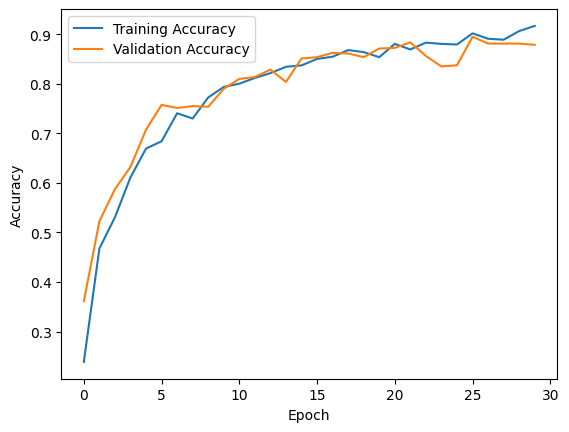

In [40]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [42]:
emotion_labels = ['anticipation','anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

while True:
    user_input = input("input: \n").lower()
    if user_input == "exit":
        print("Program selesai.")
        break

    # Hilangkan stopword pada input
    for word in stopword:
        user_input = user_input.replace(f" {word} ", " ")

    # Preprocessing input
    user_input_sequence = tokenizer.texts_to_sequences([user_input])
    user_input_padded = pad_sequences(user_input_sequence, padding=padding_type, maxlen=max_length, truncating=trunc_type)

    # Prediksi emosi menggunakan model
    prediction = model.predict(user_input_padded)
    predicted_label_index = np.argmax(prediction[0])
    predicted_emotion = emotion_labels[predicted_label_index]

    print(f"Prediksi emosi: {predicted_emotion} (Confidence: {np.max(prediction) * 100:.2f}%)")

input: 
agus takut saat uang donasi akan ditarik kembali
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Prediksi emosi: sadness (Confidence: 66.17%)
input: 
agus tidak sabar untuk menikmati uang donasi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediksi emosi: fear (Confidence: 35.70%)
input: 
agus takut akan dipukuli oleh warga
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Prediksi emosi: fear (Confidence: 41.12%)
input: 
exit
Program selesai.


In [ ]:
# def predict_sentiment(text, tokenizer, model, max_length, padding_type, trunc_type):
#     # Hilangkan stopword pada input
#     for word in stopword:
#         text = text.replace(f" {word} ", " ")

#     # Preprocess the text
#     sequence = tokenizer.texts_to_sequences([text])
#     padded_sequence = pad_sequences(sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)

#     prediction = model.predict(padded_sequence)
#     predicted_label_index = np.argmax(prediction[0]) # Get the index of the highest probability
#     sentiment_labels = ['anticipation','anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
#     predicted_sentiment = sentiment_labels[predicted_label_index]

#     return predicted_sentiment

In [ ]:
# new_text = "saya percaya dengan teman sd saya"

# predicted_sentiment = predict_sentiment(new_text, tokenizer, model, max_length, padding_type, trunc_type)

# print(f"Predicted sentiment for '{new_text}': {predicted_sentiment}")

1/1 [==============================] - 1s 1s/step
Predicted sentiment for 'saya percaya dengan teman sd saya': disgust
